<a href="https://colab.research.google.com/github/MrCogito/Spectrogram-Generator/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import TensorFlow and other libraries



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os
from google.colab import drive
import time
import librosa
import librosa.display
from keras.initializers import RandomNormal
from tensorflow.python.ops.numpy_ops import np_config
        




In [ ]:
drive.mount('/content/gdrive') #Mount google drive

Mounted at /content/gdrive


In [ ]:
tf.__version__

'2.7.0'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



SystemError: ignored

# Load and prepare the dataset

float32
(40000, 256, 8)
1.0125
0.0
1.0125
0.0
(40000, 256, 8, 1)


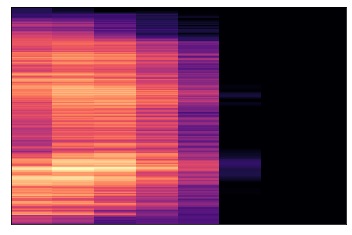

In [ ]:
# Load data

data_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_mel_spectrogram_256_8_4.npy')
#print(data_tensor)
print(data_tensor.dtype)
print(data_tensor.shape)
data_tensor = (data_tensor + 80) / 80
librosa.display.specshow(data_tensor[6642])
#print(data_tensor.shape)
print(np.max(data_tensor))
print(np.min(data_tensor))

#print(data_tensor[6699])
data_tensor[~np.isfinite(data_tensor)] = 0

data_tensor = data_tensor.reshape(40000, 256, 8, 1)
print(np.max(data_tensor))
print(np.min(data_tensor))
#data_tensor = (data_tensor + 40) / 40
#print(np.max(data_tensor))
#print(np.min(data_tensor))


print(data_tensor.shape)
BUFFER_SIZE = 40000
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(data_tensor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



ValueError: ignored

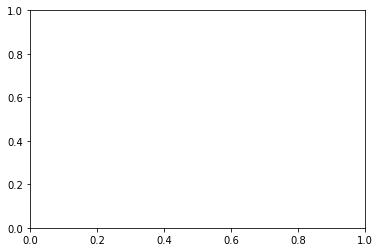

# Build the generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*1*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((32, 1, 128)))
    assert model.output_shape == (None, 32, 1, 128)  # ensure size is correct None is batch size
   
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 2, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 128, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 256, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(1, kernel_size=5, padding='same', use_bias=False, activation='sigmoid'))
    print(model.output_shape)
    
    return model





In [ ]:
generator = make_generator_model()
generator.summary()

(None, 64, 2, 128)
(None, 128, 4, 256)
(None, 256, 8, 512)
(None, 256, 8, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              409600    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 32, 1, 128)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 2, 128)       262272    
 nspose)                                                         
                                             

(1, 256, 8, 1)


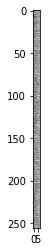

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(generated_image.shape)

#np.save("/content/gdrive/MyDrive/Inzynierka/Data/Results40/v2/test_" , generated_image)


# Build the discriminator


In [ ]:
def make_discriminator_model():
  
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',input_shape=[256, 8, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(1,activation="sigmoid"))

  return model



In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[0.50357896]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 4, 64)        1088      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 4, 64)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 33,857
Trainable params: 33,857
Non-trainable params: 0
_____________________________________________________________

# Define the loss and optimizers


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True return value in [-inf, inf]

In [ ]:
#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
    fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels))  

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)

    total_loss = (real_loss + fake_loss)
    return total_loss, fake_loss, real_loss
    

In [ ]:
#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#optimizers 
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)


# Save checkpoints


In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Save and plot history

In [ ]:
def plot_history(d1_hist, g_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(d1_hist, label='disc loss')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(g_hist, label='gen loss')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/DG_loss' + str(epochs))
	plt.close()

In [ ]:
def plot_history2(dfake_hist, dreal_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(dfake_hist, label='dfake_hist')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(dreal_hist, label='dreal_hist')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/discriminator_loss' + str(epochs))
	plt.close()

# Define the training loop

In [ ]:
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# to moze byc do wywalenia
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, fake_loss, real_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, fake_loss, real_loss


In [ ]:
def train(dataset, epochs):
  generator_hist, discriminator_hist, discriminator_fake_hist, discriminator_real_hist  = list(), list(), list(), list()
  for epoch in range(epochs):
    start = time.time()
    #
    disc_loss,gen_loss,fake_loss,real_loss = 0,0,0,0
    #
    for image_batch in dataset:
      gen_loss_change,disc_loss_change, fake_loss_change, real_loss_change = train_step(image_batch)
      gen_loss = gen_loss + gen_loss_change
      disc_loss = disc_loss + disc_loss_change
      fake_loss = fake_loss + fake_loss_change
      real_loss = real_loss + real_loss_change
    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
                             #epoch + 1,
                             #seed)
    # save generator and discriminator loss values 
    discriminator_hist.append(disc_loss)
    generator_hist.append(gen_loss)
    discriminator_fake_hist.append(fake_loss)
    discriminator_real_hist.append(real_loss)
    # Save the model every 10 epochs
    if (epoch+1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      plot_history(discriminator_hist,generator_hist,epoch)
      plot_history2(discriminator_fake_hist,discriminator_real_hist,epoch)
      generate_and_save_images(generator,epoch,seed)
      print("Generated and saved")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
#Generate and save images 
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  np.save("/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/v1_" + str(epoch), predictions)
  print(predictions.shape)
  

# Train model

Time for epoch 1 is 70.14425802230835 sec
Time for epoch 2 is 60.39000415802002 sec
Time for epoch 3 is 60.315741539001465 sec
Time for epoch 4 is 60.315613746643066 sec
Time for epoch 5 is 60.32342290878296 sec
Time for epoch 6 is 60.320611238479614 sec
Time for epoch 7 is 60.31835865974426 sec
Time for epoch 8 is 60.317084312438965 sec
Time for epoch 9 is 60.31399083137512 sec


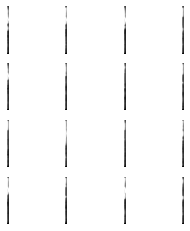

(16, 256, 8, 1)
Generated and saved
Time for epoch 10 is 65.40701341629028 sec
Time for epoch 11 is 60.31293320655823 sec
Time for epoch 12 is 60.31079649925232 sec
Time for epoch 13 is 60.32052755355835 sec
Time for epoch 14 is 60.313132524490356 sec
Time for epoch 15 is 60.325281858444214 sec
Time for epoch 16 is 60.315101623535156 sec
Time for epoch 17 is 60.31148409843445 sec
Time for epoch 18 is 60.319193601608276 sec
Time for epoch 19 is 60.32554578781128 sec


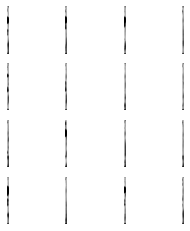

(16, 256, 8, 1)
Generated and saved
Time for epoch 20 is 64.07777261734009 sec
Time for epoch 21 is 60.319928884506226 sec
Time for epoch 22 is 60.31274628639221 sec
Time for epoch 23 is 60.311394453048706 sec
Time for epoch 24 is 60.31412601470947 sec
Time for epoch 25 is 60.314873456954956 sec
Time for epoch 26 is 60.31779360771179 sec
Time for epoch 27 is 60.318904876708984 sec
Time for epoch 28 is 60.31358504295349 sec
Time for epoch 29 is 60.3155996799469 sec


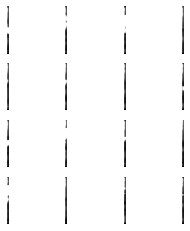

(16, 256, 8, 1)
Generated and saved
Time for epoch 30 is 63.855995416641235 sec
Time for epoch 31 is 60.320165395736694 sec
Time for epoch 32 is 60.317580223083496 sec
Time for epoch 33 is 60.30751323699951 sec
Time for epoch 34 is 60.31867432594299 sec
Time for epoch 35 is 60.3194146156311 sec
Time for epoch 36 is 60.31099796295166 sec
Time for epoch 37 is 60.31948447227478 sec
Time for epoch 38 is 60.343318939208984 sec
Time for epoch 39 is 60.32023572921753 sec


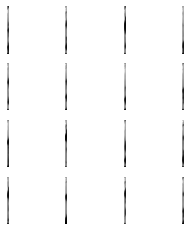

(16, 256, 8, 1)
Generated and saved
Time for epoch 40 is 61.398072719573975 sec
Time for epoch 41 is 60.305307149887085 sec
Time for epoch 42 is 60.32833528518677 sec
Time for epoch 43 is 60.31949210166931 sec
Time for epoch 44 is 60.3136100769043 sec
Time for epoch 45 is 60.32042574882507 sec
Time for epoch 46 is 60.31047868728638 sec
Time for epoch 47 is 60.31959867477417 sec
Time for epoch 48 is 60.31145668029785 sec
Time for epoch 49 is 60.31648564338684 sec


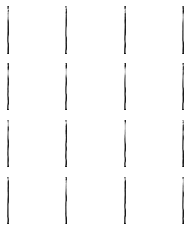

(16, 256, 8, 1)
Generated and saved
Time for epoch 50 is 61.53860950469971 sec
Time for epoch 51 is 60.319984912872314 sec
Time for epoch 52 is 60.31816554069519 sec
Time for epoch 53 is 60.31794571876526 sec
Time for epoch 54 is 60.31616282463074 sec
Time for epoch 55 is 60.310224533081055 sec
Time for epoch 56 is 60.31259083747864 sec
Time for epoch 57 is 60.31134295463562 sec
Time for epoch 58 is 60.310386180877686 sec
Time for epoch 59 is 60.313857555389404 sec


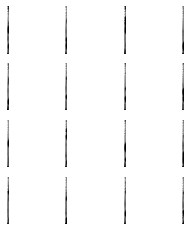

(16, 256, 8, 1)
Generated and saved
Time for epoch 60 is 61.382750511169434 sec
Time for epoch 61 is 60.32457637786865 sec
Time for epoch 62 is 60.33063316345215 sec
Time for epoch 63 is 60.30016303062439 sec
Time for epoch 64 is 60.30561900138855 sec
Time for epoch 65 is 60.304137229919434 sec
Time for epoch 66 is 60.31655788421631 sec
Time for epoch 67 is 60.30447435379028 sec
Time for epoch 68 is 60.30641770362854 sec
Time for epoch 69 is 60.308305978775024 sec


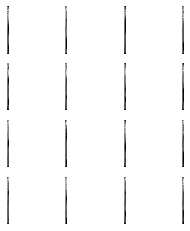

(16, 256, 8, 1)
Generated and saved
Time for epoch 70 is 61.34421992301941 sec
Time for epoch 71 is 60.305418491363525 sec
Time for epoch 72 is 60.30573320388794 sec
Time for epoch 73 is 60.3175482749939 sec
Time for epoch 74 is 60.31256318092346 sec
Time for epoch 75 is 60.33192825317383 sec
Time for epoch 76 is 60.32374835014343 sec
Time for epoch 77 is 60.31526732444763 sec
Time for epoch 78 is 60.32040977478027 sec
Time for epoch 79 is 60.30999493598938 sec


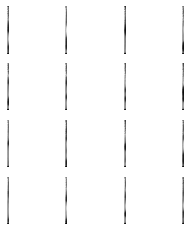

(16, 256, 8, 1)
Generated and saved
Time for epoch 80 is 61.55437159538269 sec
Time for epoch 81 is 60.31659483909607 sec
Time for epoch 82 is 82.06762409210205 sec
Time for epoch 83 is 60.33018517494202 sec
Time for epoch 84 is 60.30661153793335 sec
Time for epoch 85 is 60.310678005218506 sec
Time for epoch 86 is 60.308037996292114 sec
Time for epoch 87 is 60.30540227890015 sec
Time for epoch 88 is 60.302623987197876 sec
Time for epoch 89 is 60.31430220603943 sec


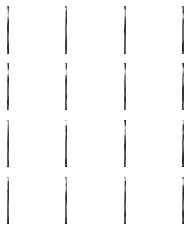

(16, 256, 8, 1)
Generated and saved
Time for epoch 90 is 61.34945797920227 sec
Time for epoch 91 is 60.29953050613403 sec
Time for epoch 92 is 60.29425883293152 sec
Time for epoch 93 is 60.29877972602844 sec
Time for epoch 94 is 60.322208881378174 sec
Time for epoch 95 is 60.308778524398804 sec
Time for epoch 96 is 60.30090880393982 sec
Time for epoch 97 is 60.29644703865051 sec
Time for epoch 98 is 60.29823565483093 sec
Time for epoch 99 is 60.29245710372925 sec


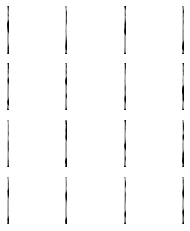

(16, 256, 8, 1)
Generated and saved
Time for epoch 100 is 61.50370788574219 sec
Time for epoch 101 is 60.296334743499756 sec
Time for epoch 102 is 60.29417395591736 sec
Time for epoch 103 is 60.29451584815979 sec
Time for epoch 104 is 60.29331827163696 sec
Time for epoch 105 is 60.30008244514465 sec
Time for epoch 106 is 60.286558866500854 sec
Time for epoch 107 is 60.2974591255188 sec
Time for epoch 108 is 60.29759168624878 sec
Time for epoch 109 is 60.303130865097046 sec


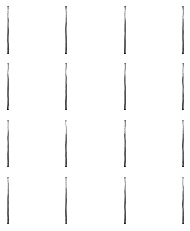

(16, 256, 8, 1)
Generated and saved
Time for epoch 110 is 61.35069799423218 sec
Time for epoch 111 is 60.31077027320862 sec
Time for epoch 112 is 60.30691719055176 sec
Time for epoch 113 is 60.308300256729126 sec
Time for epoch 114 is 60.30668115615845 sec
Time for epoch 115 is 60.31859517097473 sec
Time for epoch 116 is 60.30250358581543 sec
Time for epoch 117 is 60.30555582046509 sec
Time for epoch 118 is 60.32102155685425 sec
Time for epoch 119 is 60.30763578414917 sec


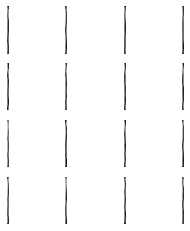

(16, 256, 8, 1)
Generated and saved
Time for epoch 120 is 61.3377320766449 sec
Time for epoch 121 is 60.304943799972534 sec
Time for epoch 122 is 60.295775413513184 sec
Time for epoch 123 is 60.29031682014465 sec
Time for epoch 124 is 60.3013072013855 sec
Time for epoch 125 is 60.30490064620972 sec
Time for epoch 126 is 60.30431842803955 sec
Time for epoch 127 is 60.30196762084961 sec
Time for epoch 128 is 60.302091121673584 sec
Time for epoch 129 is 60.298397064208984 sec


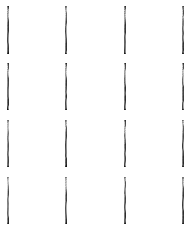

(16, 256, 8, 1)
Generated and saved
Time for epoch 130 is 61.55762529373169 sec
Time for epoch 131 is 60.30040431022644 sec
Time for epoch 132 is 60.30844187736511 sec
Time for epoch 133 is 60.313562631607056 sec
Time for epoch 134 is 60.310768365859985 sec
Time for epoch 135 is 60.30962777137756 sec
Time for epoch 136 is 60.306700468063354 sec
Time for epoch 137 is 60.29825186729431 sec
Time for epoch 138 is 60.302765130996704 sec
Time for epoch 139 is 60.30607008934021 sec


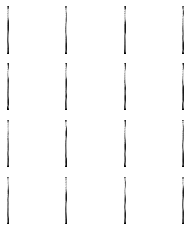

(16, 256, 8, 1)
Generated and saved
Time for epoch 140 is 61.34295082092285 sec
Time for epoch 141 is 60.308711767196655 sec
Time for epoch 142 is 60.309019565582275 sec
Time for epoch 143 is 60.30031108856201 sec
Time for epoch 144 is 60.30500292778015 sec
Time for epoch 145 is 60.305480003356934 sec
Time for epoch 146 is 60.31686758995056 sec
Time for epoch 147 is 60.30915379524231 sec
Time for epoch 148 is 60.32056498527527 sec
Time for epoch 149 is 60.31065058708191 sec


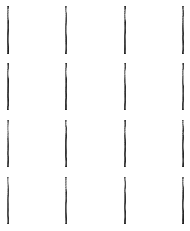

(16, 256, 8, 1)
Generated and saved
Time for epoch 150 is 61.37986636161804 sec
Time for epoch 151 is 60.31042981147766 sec
Time for epoch 152 is 60.30400514602661 sec
Time for epoch 153 is 60.30850696563721 sec
Time for epoch 154 is 60.311317443847656 sec
Time for epoch 155 is 60.308446645736694 sec
Time for epoch 156 is 60.301562786102295 sec
Time for epoch 157 is 60.310636043548584 sec
Time for epoch 158 is 60.302369832992554 sec
Time for epoch 159 is 60.29876971244812 sec


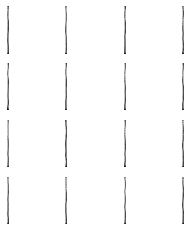

(16, 256, 8, 1)
Generated and saved
Time for epoch 160 is 61.5839147567749 sec
Time for epoch 161 is 60.31720447540283 sec
Time for epoch 162 is 60.31861996650696 sec
Time for epoch 163 is 60.29787826538086 sec
Time for epoch 164 is 60.30173850059509 sec
Time for epoch 165 is 60.298341035842896 sec
Time for epoch 166 is 60.30079936981201 sec
Time for epoch 167 is 60.3094482421875 sec
Time for epoch 168 is 60.289839029312134 sec
Time for epoch 169 is 60.30051136016846 sec


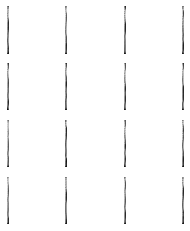

(16, 256, 8, 1)
Generated and saved
Time for epoch 170 is 61.375301361083984 sec
Time for epoch 171 is 60.294692516326904 sec
Time for epoch 172 is 60.32126450538635 sec
Time for epoch 173 is 60.30155968666077 sec
Time for epoch 174 is 60.293198347091675 sec
Time for epoch 175 is 60.2959463596344 sec
Time for epoch 176 is 60.296058177948 sec
Time for epoch 177 is 60.29853868484497 sec
Time for epoch 178 is 60.307416677474976 sec
Time for epoch 179 is 60.2934889793396 sec


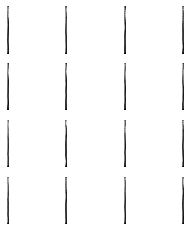

(16, 256, 8, 1)
Generated and saved
Time for epoch 180 is 61.32703685760498 sec
Time for epoch 181 is 60.29267716407776 sec
Time for epoch 182 is 60.29661154747009 sec
Time for epoch 183 is 60.299044609069824 sec
Time for epoch 184 is 60.3000602722168 sec
Time for epoch 185 is 60.30657482147217 sec
Time for epoch 186 is 60.302574634552 sec
Time for epoch 187 is 60.30479025840759 sec
Time for epoch 188 is 60.303555965423584 sec
Time for epoch 189 is 60.32461643218994 sec


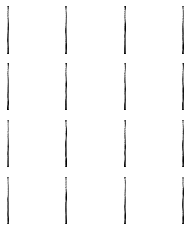

(16, 256, 8, 1)
Generated and saved
Time for epoch 190 is 61.578617095947266 sec
Time for epoch 191 is 60.32280921936035 sec
Time for epoch 192 is 60.30809807777405 sec
Time for epoch 193 is 60.30154204368591 sec
Time for epoch 194 is 60.30229616165161 sec
Time for epoch 195 is 60.310508012771606 sec
Time for epoch 196 is 60.29878830909729 sec
Time for epoch 197 is 60.31884813308716 sec
Time for epoch 198 is 60.30071210861206 sec
Time for epoch 199 is 60.30893540382385 sec


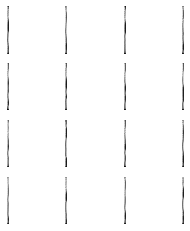

(16, 256, 8, 1)
Generated and saved
Time for epoch 200 is 61.37720346450806 sec
Time for epoch 201 is 60.31056594848633 sec
Time for epoch 202 is 60.300315380096436 sec
Time for epoch 203 is 60.30494976043701 sec
Time for epoch 204 is 60.29908466339111 sec
Time for epoch 205 is 60.3219575881958 sec
Time for epoch 206 is 60.301576137542725 sec
Time for epoch 207 is 60.30199575424194 sec
Time for epoch 208 is 60.29579520225525 sec
Time for epoch 209 is 60.30033278465271 sec


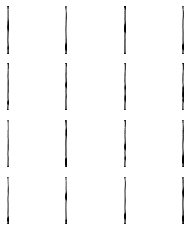

(16, 256, 8, 1)
Generated and saved
Time for epoch 210 is 61.36642670631409 sec
Time for epoch 211 is 60.30238962173462 sec
Time for epoch 212 is 60.30367588996887 sec
Time for epoch 213 is 60.31565856933594 sec
Time for epoch 214 is 60.306018114089966 sec
Time for epoch 215 is 60.296167850494385 sec
Time for epoch 216 is 60.30426573753357 sec
Time for epoch 217 is 60.2963490486145 sec
Time for epoch 218 is 60.30936789512634 sec
Time for epoch 219 is 60.29949378967285 sec


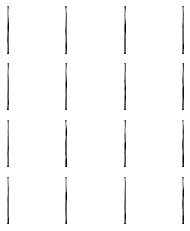

(16, 256, 8, 1)
Generated and saved
Time for epoch 220 is 61.53896522521973 sec
Time for epoch 221 is 60.29325556755066 sec
Time for epoch 222 is 60.30018997192383 sec
Time for epoch 223 is 60.29360556602478 sec
Time for epoch 224 is 60.301825761795044 sec
Time for epoch 225 is 60.29248666763306 sec
Time for epoch 226 is 60.29294943809509 sec
Time for epoch 227 is 60.30167603492737 sec
Time for epoch 228 is 60.30197048187256 sec
Time for epoch 229 is 60.29966998100281 sec


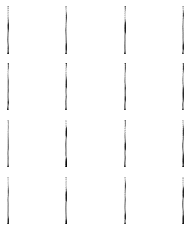

(16, 256, 8, 1)
Generated and saved
Time for epoch 230 is 61.315021991729736 sec
Time for epoch 231 is 60.297465562820435 sec
Time for epoch 232 is 60.309852838516235 sec
Time for epoch 233 is 60.3073947429657 sec
Time for epoch 234 is 60.305485010147095 sec
Time for epoch 235 is 60.307326316833496 sec
Time for epoch 236 is 60.298600912094116 sec
Time for epoch 237 is 60.32335591316223 sec
Time for epoch 238 is 60.30198812484741 sec
Time for epoch 239 is 60.30398368835449 sec


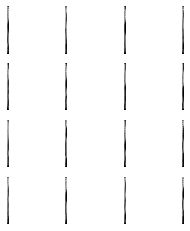

(16, 256, 8, 1)
Generated and saved
Time for epoch 240 is 61.31379294395447 sec
Time for epoch 241 is 60.2998480796814 sec
Time for epoch 242 is 60.305548429489136 sec
Time for epoch 243 is 60.32447934150696 sec
Time for epoch 244 is 60.3013334274292 sec
Time for epoch 245 is 60.295379638671875 sec
Time for epoch 246 is 60.31710195541382 sec
Time for epoch 247 is 60.306137561798096 sec
Time for epoch 248 is 60.299373626708984 sec
Time for epoch 249 is 60.328797817230225 sec


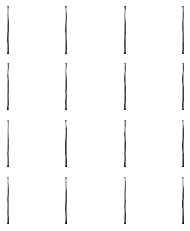

(16, 256, 8, 1)
Generated and saved
Time for epoch 250 is 61.63714551925659 sec


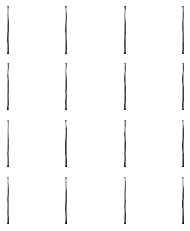

(16, 256, 8, 1)


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generate_and_save_images(generator, 60, seed)

NameError: ignored

(16, 256, 8, 1)
0.96906674
5.4335287e-30
-2.4746628
-80.0


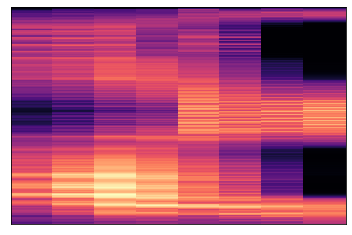

In [ ]:
import librosa
import librosa.display
zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/Results_mel/v1/v1_129.npy')
#zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/common_voice_en_22677141.mp3.npy')
print(zaladowane.shape)
#print(zaladowane[6])
print(np.max(zaladowane))
print(np.min(zaladowane))
zaladowane = (zaladowane * 80) - 80
print(np.max(zaladowane))
print(np.min(zaladowane))
#print(zaladowane)
#librosa.display.specshow(spectest)
librosa.display.specshow((zaladowane[1].reshape(256,8)))
#librosa.display.specshow((normalized[1].reshape(256,16)))
#print(normalized[2])

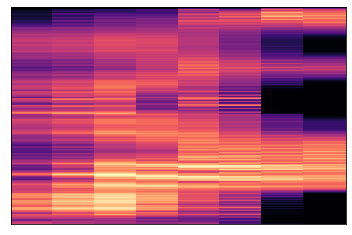

In [ ]:
librosa.display.specshow((zaladowane[10].reshape(256,8)))

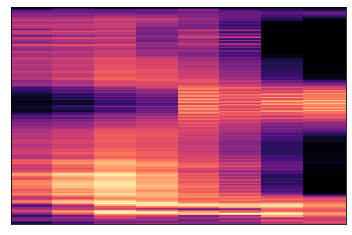

In [ ]:
librosa.display.specshow((zaladowane[11].reshape(256,8)))

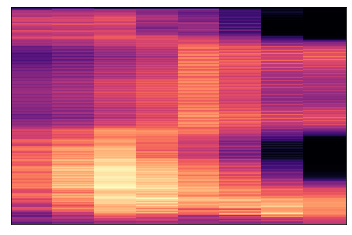

In [ ]:
librosa.display.specshow((zaladowane[12].reshape(256,8)))

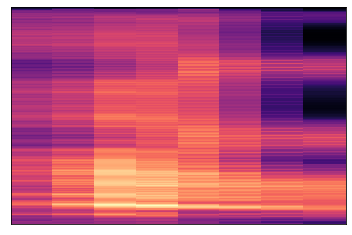

In [ ]:
librosa.display.specshow((zaladowane[8].reshape(256,8)))

In [ ]:
librosa.display.specshow((zaladowane[12].reshape(256,16)))

ValueError: ignored

In [ ]:
# To restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
